# Code from `gradio_pose2image.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.openpose import OpenposeDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

from PIL import Image
import lpw

/home/jimgoo/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [3]:
apply_openpose = OpenposeDetector()

model = create_model("./models/cldm_v15.yaml").cpu()
model.load_state_dict(
    load_state_dict("./models/control_sd15_openpose.pth", location="cuda")
)
model = model.cuda()
ddim_sampler = DDIMSampler(model)

#
# Load embedding
#
model.cond_stage_model.load_textual_inversion_embeddings(
    [
        "ti_embeddings/neon.pt",
        "ti_embeddings/CharTurner.pt",
    ],
    allow_replacement=False,
)


cuda
cuda
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_openpose.pth]


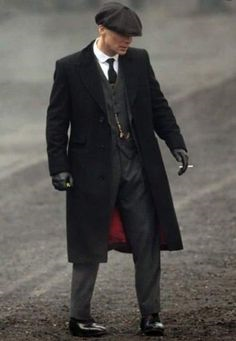

In [4]:
input_image = Image.open('test_imgs/pose2.png')
input_image

In [5]:
num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
detect_resolution = 512
ddim_steps = 20
scale = 9.0
seed = 42
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

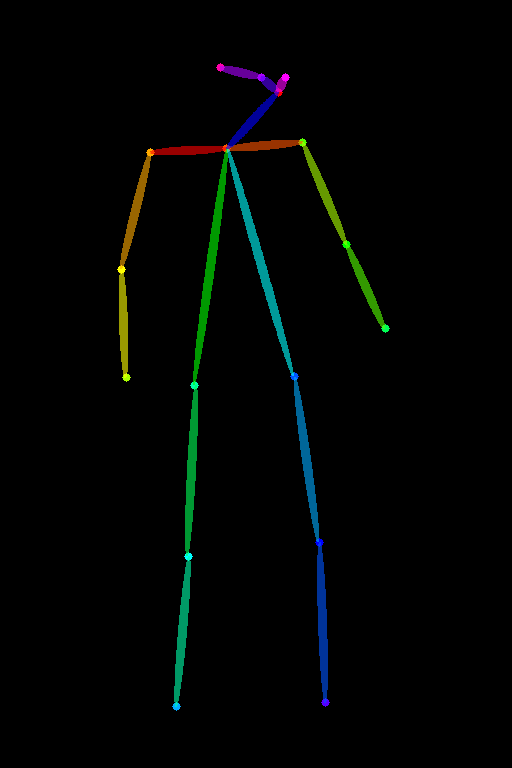

In [6]:
with torch.no_grad():
    input_image = HWC3(np.array(input_image))
    detected_map, _ = apply_openpose(resize_image(input_image, detect_resolution))
    detected_map = HWC3(detected_map)
    img = resize_image(input_image, image_resolution)
    H, W, C = img.shape

    detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

Image.fromarray(detected_map)

## an astronaut on the moon

In [7]:
prompt = 'an astronaut on the moon'
prompt

'an astronaut on the moon'

In [8]:
def sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples):
    with torch.no_grad():
    #     input_image = HWC3(np.array(input_image))
    #     detected_map, _ = apply_openpose(resize_image(input_image, detect_resolution))
    #     detected_map = HWC3(detected_map)
    #     img = resize_image(input_image, image_resolution)
    #     H, W, C = img.shape

    #     detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, "b h w c -> b c h w").clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {
            "c_concat": [control],
            #"c_crossattn": [model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)],
            "c_crossattn": cond_c_crossattn,
        }
        un_cond = {
            "c_concat": None if guess_mode else [control],
            # "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
            "c_crossattn": uncond_c_crossattn,
        }
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = (
            [strength * (0.825 ** float(12 - i)) for i in range(13)]
            if guess_mode
            else ([strength] * 13)
        )
        samples, intermediates = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )

        results = [x_samples[i] for i in range(num_samples)]

    return [Image.fromarray(x) for x in x_samples]

### original non-LPW version

In [9]:
cond_c_crossattn = [model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)]
uncond_c_crossattn = [model.get_learned_conditioning([n_prompt] * num_samples)]

In [10]:
imgs_orig = sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 96, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.52it/s]


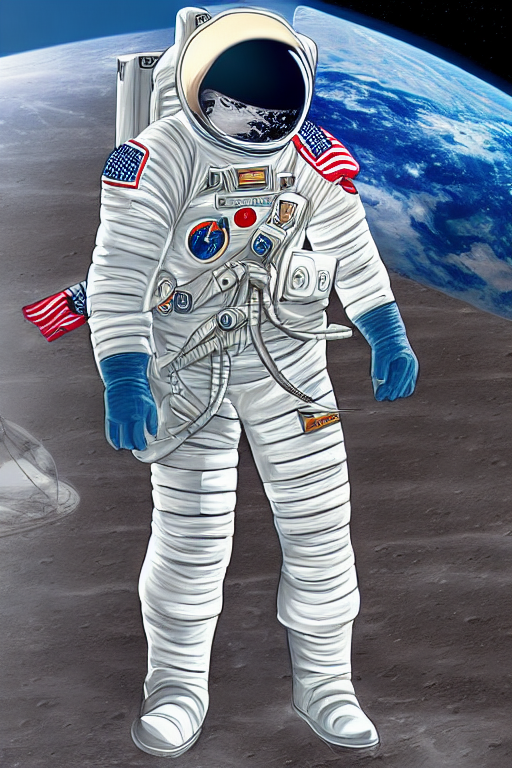

In [11]:
imgs_orig[0]

### LPW version

In [12]:
text_embeddings, uncond_embeddings = lpw.get_weighted_text_embeddings(
    model.cond_stage_model.tokenizer,
    model.cond_stage_model.transformer,
    [prompt + ", " + a_prompt] * num_samples,
    [n_prompt] * num_samples,
    max_embeddings_multiples=3,
)

cond_c_crossattn = [text_embeddings]
uncond_c_crossattn = [uncond_embeddings]

In [13]:
imgs_lpw = sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 96, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50it/s]


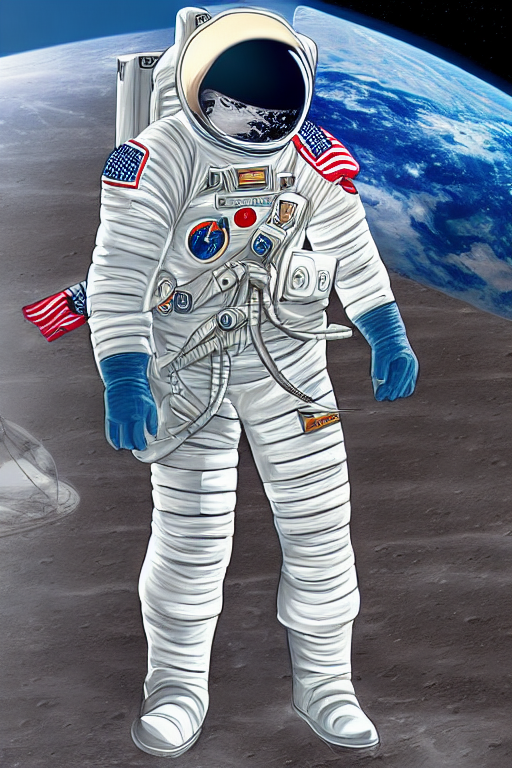

In [14]:
imgs_lpw[0]

#### More weight on the word moon

In [24]:
text_embeddings, uncond_embeddings = lpw.get_weighted_text_embeddings(
    model.cond_stage_model.tokenizer,
    model.cond_stage_model.transformer,
    ["an astronaut on the ((moon))" + ", " + a_prompt] * num_samples,
    [n_prompt] * num_samples,
    max_embeddings_multiples=3,
)

cond_c_crossattn = [text_embeddings]
uncond_c_crossattn = [uncond_embeddings]

In [25]:
imgs_lpw = sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 96, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.50it/s]


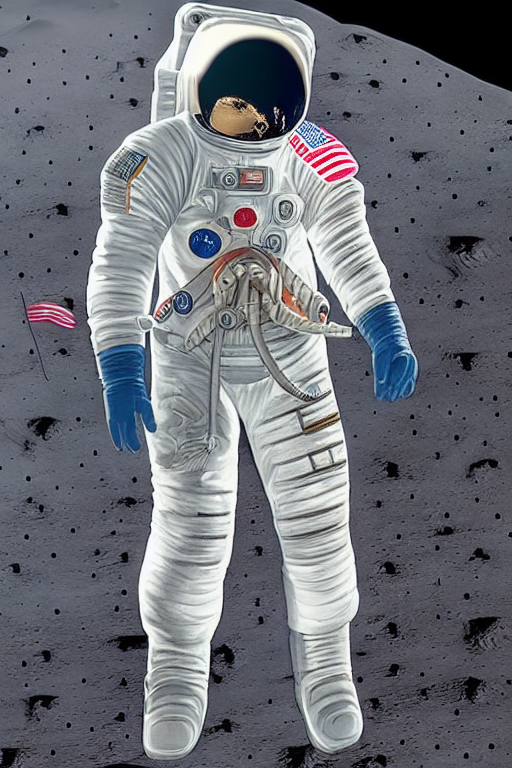

In [26]:
imgs_lpw[0]

## Using a prompt > 77 tokens - 'astronaut on the moon' is at the end

In [15]:
prompt = ['an']*80
prompt = ' '.join(prompt)  + ' astronaut on the moon'
prompt

'an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an astronaut on the moon'

### original non-LPW version

In [16]:
# overflowing_tokens shows tokens over the limt of the tokenizer 
tokenizer = model.cond_stage_model.tokenizer
max_length = model.cond_stage_model.max_length
batch_enc = tokenizer(prompt, truncation=True, max_length=max_length, return_length=True,
                      return_overflowing_tokens=True, padding="max_length", return_tensors="pt")

In [17]:
batch_enc

{'overflowing_tokens': tensor([[  550,   550,   550,   550,   550, 18376,   525,   518,  3293]]), 'num_truncated_tokens': tensor([9]), 'input_ids': tensor([[49406,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550,   550,   550,   550,   550,
           550,   550,   550,   550,   550,   550, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
cond_c_crossattn = [model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)]
uncond_c_crossattn = [model.get_learned_conditioning([n_prompt] * num_samples)]

In [19]:
imgs_orig = sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 96, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.50it/s]


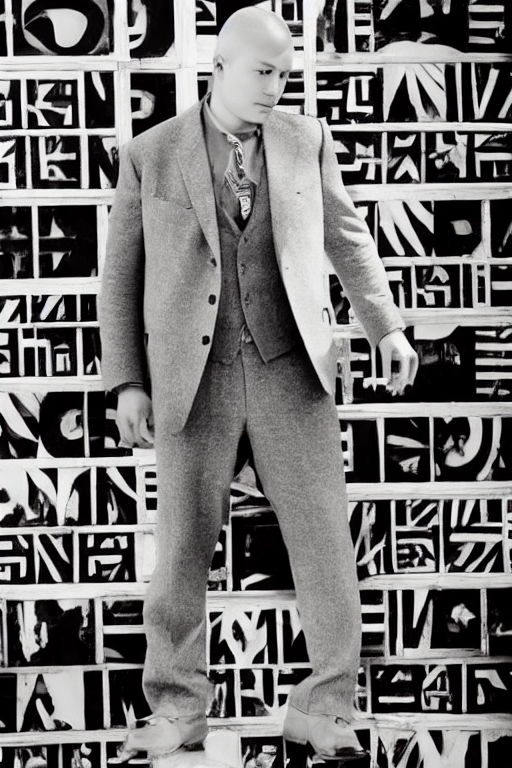

In [20]:
imgs_orig[0]

### LPW version 

In [21]:
text_embeddings, uncond_embeddings = lpw.get_weighted_text_embeddings(
    model.cond_stage_model.tokenizer,
    model.cond_stage_model.transformer,
    [prompt + ", " + a_prompt] * num_samples,
    [n_prompt] * num_samples,
    max_embeddings_multiples=3,
)

cond_c_crossattn = [text_embeddings]
uncond_c_crossattn = [uncond_embeddings]

In [22]:
imgs_lpw = sample_images(cond_c_crossattn, uncond_c_crossattn, seed, strength, ddim_steps, num_samples)

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 96, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.47it/s]


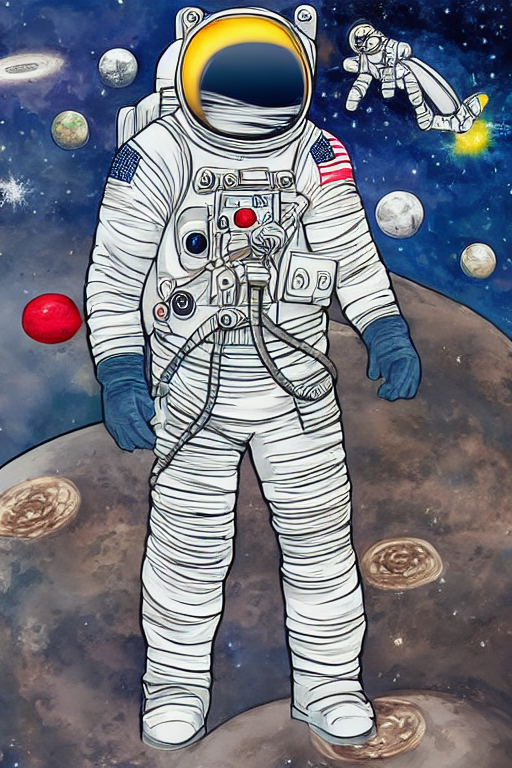

In [23]:
imgs_lpw[0]